In [42]:
from IPython.display import Image, display
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel
import pyodbc
import os
from typing import Annotated
import operator
from pydantic import Field
from datetime import datetime

load_dotenv()
llm = ChatOpenAI(
    model="gpt-4o"
    )

In [43]:

class Prededente(BaseModel):
    tipo: str
    detalle: str

class PrecedentePerspectivas(BaseModel):
    precedentes: List[Prededente]

class Consumo(BaseModel):
    detalle: str

class ConsumoPerspectivas(BaseModel):
    detalle: Consumo

class RecopilarDatosState(TypedDict):
    informacion_precedente: str
    consulta_precedente: str
    consulta_sql: Annotated[list, operator.add]
    resumen_precedente: List[Prededente]
    id: int
    edad: int
    informacion_compras: str
    consulta_stock: str
    resumen_consumo: Consumo
    messages: str
    context: Annotated[list, operator.add]
    max_num_turns: int
    interview: str
    sections: str
    enfermedades: List[str]

conn_str = (
    "Driver={ODBC Driver 17 for SQL Server};"
    f"Server=tcp:{os.environ.get('AZURE_SQL_ENDPOINT')},1433;"
    f"Database={os.environ.get('AZURE_SQL_DB')};"
    f"Uid={os.environ.get('AZURE_SQL_USER')};"
    f"Pwd={os.environ.get('AZURE_SQL_PASS')};"
    "Encrypt=yes;"
    "TrustServerCertificate=no;"
    "Connection Timeout=30;"
)

In [44]:
def consulta_a_sql(state: RecopilarDatosState):
    connection = pyodbc.connect(conn_str)
    cursor = connection.cursor()
    for query in state['consulta_sql']:
        cursor.execute(query, (state['id'],))
        rows = cursor.fetchall()
        columns = [column[0] for column in cursor.description]
        result = [dict(zip(columns, row)) for row in rows]
        if '[dbo].[RecPrecedentes]' in query:
            state['informacion_precedente'] = str([p['Detalle'] for p in result])
        else:
            state['informacion_compras'] = str([f"Producto:{p['Nombre']}, Cantidad:{p['Cantidad']}, Vencimiento:{p['FechaVencimiento']}" for p in result])
    connection.close()
    return state

def traer_datos(state: RecopilarDatosState):
    state['consulta_sql'] = ["SELECT Detalle FROM [dbo].[RecPrecedentes] WHERE IdUsuario = ?;", "SELECT Nombre, Cantidad, FechaVencimiento FROM [dbo].[Productos] WHERE IdBoleta IN (SELECT IdBoleta FROM [dbo].[Boleta] WHERE IdUsuario = ?);"]
    return consulta_a_sql(state)

In [45]:
precedentes_instrucciones="""You are tasked with understanding the following data. Follow these instructions carefully:

1. First, review all the information that will serve as an entry point. The multiple data are hosted as a elements in a Python list:
{informacion_precedente}
        
2. Group, synthesise and relate similar elements in individual paragraphs.

3. Each paragraph should have a main heading and a corresponding detail."""

def crear_resumen_precedente(state: RecopilarDatosState):   
    informacion_precedente=state['informacion_precedente']
    edad=state['edad']
    structured_llm = llm.with_structured_output(PrecedentePerspectivas)
    system_message = precedentes_instrucciones.format(informacion_precedente=informacion_precedente, edad=edad)
    precedentes = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of paragraphs.")])
    return {"resumen_precedente": precedentes.precedentes}

In [46]:
consumo_instrucciones="""You are tasked with understanding the following data. Follow these instructions carefully:

1. First, review all the information that will serve as an entry point. The multiple data are hosted as a elements in a Python list:
{informacion_compras}
        
2. Group product types together to describe which types of products by category are most often consumed and which are least consumed.

3. To carry out the analysis, do not forget to consider quantities and dates of each of the products.

4. Provide an overview explaining this detail in a single paragraph containing only the content without headings."""


def crear_resumen_consumos(state: RecopilarDatosState):   
    informacion_compras=state['informacion_compras']
    structured_llm = llm.with_structured_output(ConsumoPerspectivas)
    system_message = consumo_instrucciones.format(informacion_compras=informacion_compras)
    consumo = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the paragraph.")])
    state["resumen_consumo"] = consumo.detalle
    return state

In [47]:

class SearchQuery(BaseModel):
    search_query: str = Field(None)

In [48]:
question_instructions = """You are one person tasked with asking an expert about possible diseases you could develop by over-consuming certain types of products.. 

Your objective is to identify diseases based on the history of product purchases you have been making over the last few months, taking into account the quantities of each product.

In addition, you should take into account certain discomforts that you have already noticed in your body when you eat certain types of food. 

Here are your available products: {compras} 

Here are the discomforts you have identified: {malestares}

Start by introducing yourself by mentioning the quantities and types of products you have been consuming. Similarly, highlight the discomforts you have detected, and then ask the question.

Keep asking yourself questions to dig deeper and understand what kinds of possible diseases you might be developing without even noticing discomfort. but which are strongly related to the products you consume. 

When you are satisfied with the alternatives, complete the interview with: "Thank you very much for your help!"

Remember to stay in character throughout your response, reflecting the person and objectives provided to you."""

def generar_pregunta(state: RecopilarDatosState):
    compras = state["resumen_consumo"]
    malestares  = state["resumen_precedente"]

    system_message = question_instructions.format(compras=compras, malestares=malestares)
    question = llm.invoke([SystemMessage(content=system_message)])
    return {"messages": [question]}

In [49]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader

tavily_search = TavilySearchResults(max_results=3)

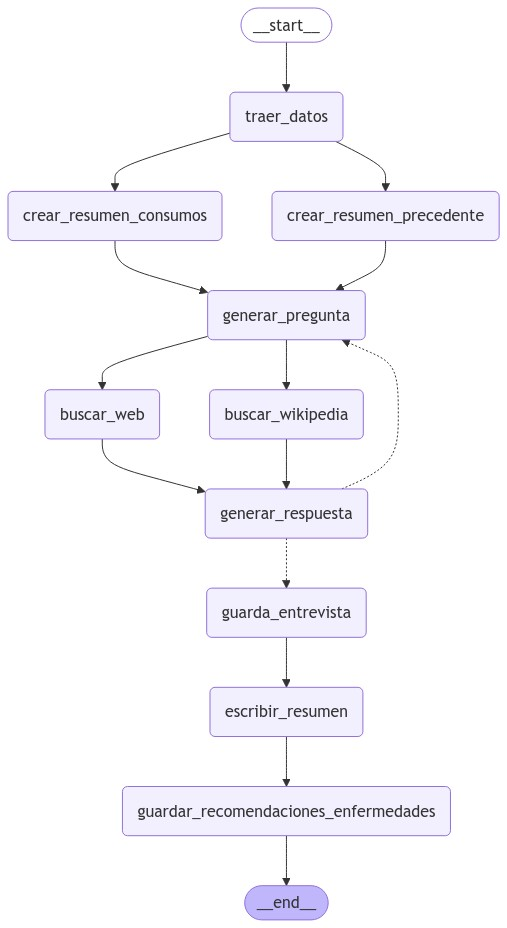

In [50]:
from langchain_core.messages import get_buffer_string

search_instructions = SystemMessage(content=f"""You will be given a conversation between an person and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full text.

Pay particular attention to the final question posed by the person.

Convert this final question into a well-structured web search query""")

def buscar_web(state: RecopilarDatosState):
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    search_docs = tavily_search.invoke(search_query.search_query)
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def buscar_wikipedia(state: RecopilarDatosState):
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

    # formatted_search_docs = "\n\n---\n\n".join(
    #     [
    #         f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
    #         for doc in search_docs
    #     ]
    # )

    return {"context": [search_docs]} 

answer_instructions = """You are an expert being interviewed by a person.

Here is the person who has the following purchase and consumption history: {resumen_consumo}. 

Also, here are the ailments he/she reports: {resumen_precedente}
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. Do not focus only on the listed complaints to generate recommendations. Focus primarily on providing recommendations that address both the ailments and the products being consumed together.

4. Similarly, considering the quantities of products purchased is an important point.

5. Avoid giving general recommendations or recommendations based solely on the person's symptoms.

6. Each recommendation is an independent paragraph and it should be related to the person's product history.

7. At the end of each recommendation you must indicate the product(s) that are related to the recommendation and are present in the person purchase history.

8. Eliminate connectors such as ‘Finally’

And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generar_respuesta(state: RecopilarDatosState):
    
    resumen_consumo = state["resumen_consumo"]
    resumen_precedente  = state["resumen_precedente"]
    messages = state["messages"]
    context = state["context"]

    system_message = answer_instructions.format(resumen_consumo=resumen_consumo, resumen_precedente=resumen_precedente, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    answer.name = "expert"
    
    return {"messages": [answer]}


def guarda_entrevista(state: RecopilarDatosState):
    messages = state["messages"]
    interview = get_buffer_string(messages)
    return {"interview": interview}

def enrutar_mensaje(state: RecopilarDatosState, 
                   name: str = "expert"):

    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',1)
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )
    if num_responses >= max_num_turns:
        return 'guarda_entrevista'

    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'guarda_entrevista'
    return "generar_pregunta"

system_message = """You are an expert technical writer and have extensive knowledge of human medicine.
            
Your task is to create short paragraphs to explain and summarise each developmental analysis of possible diseases. 

1. Analyse the content and summarise each block of text in small paragraphs. 

2. Omit closing paragraphs that contain general text like:
    - By aligning your consumption habits with these recommendations, you can mitigate some discomforts and maintain better overall health.
    - These recommendations align with your current consumption patterns, focusing on maintaining a balanced diet while addressing potential health concerns.

2. Join the paragraphs into a single paragraph using "|" pipe delimiter. Removes any special characters or line breaks from the content.

"""

def escribir_resumen(state: RecopilarDatosState):

    context = state["messages"]
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write the required content: {context}")]) 
    return {"sections": [section.content]}

def escribir_a_sql(state: RecopilarDatosState):
    connection = pyodbc.connect(conn_str)
    cursor = connection.cursor()
    query='INSERT INTO RecEnfermedades (Detalle, FechaRecomendacion, IdUsuario) VALUES (?,?,?);'
    id = state['id']
    today = datetime.now().strftime("%Y-%m-%d")
    try:
        for enfermedad in state['enfermedades']:
            cursor.execute(query, (enfermedad, today, id,),)
            connection.commit()
        print("Data inserted successfully.")
    except Exception as e:
        print("An error occurred:", e)
    connection.close()
    return state

def guardar_recomendaciones_enfermedades(state: RecopilarDatosState):
    state['enfermedades'] = [receta.strip() for receta in state['sections'][0].split('|')]
    escribir_a_sql(state)

builder = StateGraph(RecopilarDatosState)
builder.add_node("traer_datos", traer_datos)
builder.add_node("crear_resumen_precedente", crear_resumen_precedente)
builder.add_node("crear_resumen_consumos", crear_resumen_consumos)
builder.add_node("generar_pregunta", generar_pregunta)
builder.add_node("buscar_web", buscar_web)
builder.add_node("buscar_wikipedia", buscar_wikipedia)
builder.add_node("generar_respuesta", generar_respuesta)
builder.add_node("guarda_entrevista", guarda_entrevista)
builder.add_node("escribir_resumen", escribir_resumen)
builder.add_node("guardar_recomendaciones_enfermedades", guardar_recomendaciones_enfermedades)

builder.add_edge(START, "traer_datos")
builder.add_edge("traer_datos", "crear_resumen_precedente")
builder.add_edge("traer_datos", "crear_resumen_consumos")
builder.add_edge("crear_resumen_precedente", "generar_pregunta")
builder.add_edge("crear_resumen_consumos", "generar_pregunta")
builder.add_edge("generar_pregunta", "buscar_web")
builder.add_edge("generar_pregunta", "buscar_wikipedia")
builder.add_edge("buscar_web", "generar_respuesta")
builder.add_edge("buscar_wikipedia", "generar_respuesta")
builder.add_conditional_edges("generar_respuesta", enrutar_mensaje,['generar_pregunta','guarda_entrevista'])
builder.add_edge("guarda_entrevista", "escribir_resumen")
builder.add_edge("escribir_resumen", "guardar_recomendaciones_enfermedades")
builder.add_edge("guardar_recomendaciones_enfermedades", END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [51]:
id = 1
edad = 22
thread = {"configurable": {"thread_id": "1"}}

events = graph.stream({"id":id, "edad":edad}, thread, stream_mode="values")
for event in events:
    sections = event.get('sections', '')
    print(sections)








["Your high consumption of acidic fruits, such as oranges, may worsen symptoms related to acidity, like the stomach burning sensation you experience after eating condiments. It is essential to balance these with more alkaline foods to maintain a healthy pH level in your body, as an acidic environment can lead to conditions like acidosis, which might help reduce acidity-related discomforts. | While you haven't reported any discomfort specifically linked to dairy, it is crucial to monitor for emerging symptoms since dairy is acidic and could contribute to an acidic body environment. Balancing dairy intake with alkaline foods, like fruits and vegetables, may be beneficial in preventing potential issues. | Due to your gluten intolerance and frequent consumption of baked goods, it is important to reduce or eliminate gluten-containing items like bread and cookies to avoid severe abdominal pain and diarrhea. Continued gluten consumption despite intolerance can cause long-term gastroint